In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("startup_data.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

def handle_missing_values(df):
    # 결측치 현황 확인
    missing_info = df.isnull().sum()
    print("결측치 현황:")
    print(missing_info[missing_info > 0])
    print("\n")
    
    # 마일스톤 관련 결측치 처리
    df['age_first_milestone_year'] = df['age_first_milestone_year'].fillna(0)
    df['age_last_milestone_year'] = df['age_last_milestone_year'].fillna(0)
    
    # 결측치 처리 후 확인
    missing_after = df.isnull().sum()
    print("결측치 처리 후 현황:")
    print(missing_after[missing_after > 0])
    
    return df


def plot_feature_importance(model, feature_names, title="Feature Importance"):
    """특성 중요도 시각화"""
    importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=True)
    plt.figure(figsize=(12, 6))
    importance.plot(kind='barh')
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(model, X_test, y_test, title="ROC Curve"):
    """ROC 커브 시각화"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    return roc_auc

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """혼동 행렬 시각화"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return cm

def evaluate_model(model, X_test, y_test, feature_names, title_prefix=""):
    """모델 종합 평가 및 시각화"""
    # 예측
    y_pred = model.predict(X_test)
    
    # 1. 혼동 행렬
    cm = plot_confusion_matrix(y_test, y_pred, 
                             title=f"{title_prefix} Confusion Matrix")
    
    # 2. ROC 커브
    roc_auc = plot_roc_curve(model, X_test, y_test, 
                            title=f"{title_prefix} ROC Curve")
    
    # 3. 특성 중요도
    plot_feature_importance(model, feature_names, 
                          title=f"{title_prefix} Feature Importance")
    
    # 4. F1 Score 계산
    f1 = f1_score(y_test, y_pred)
    
    results = {
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'f1_score': f1
    }
    
    # 결과 출력
    print(f"\n{title_prefix} Results:")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 1에 대한 Precision과 Recall 계산
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return results

def run_baseline_experiment(X, y):
    """기본 XGBoost 실험"""
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 모델 학습
    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # 평가 및 시각화
    results = evaluate_model(model, X_test, y_test, 
                           X.columns, "Baseline XGBoost")
    
    return model, results

In [88]:
from sklearn.model_selection import train_test_split

main_columns = [
    # 위치 관련
    'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate',
    
    # 기업 기본 정보
    'founded_at', #'closed_at',
    
    # 펀딩 관련 정보
    'first_funding_at', 'last_funding_at',
    'age_first_funding_year', 'age_last_funding_year',
    'funding_rounds', 'funding_total_usd',
    'avg_participants',
    
    # 투자 유형
    'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 
    'has_roundC', 'has_roundD',
    
    # 마일스톤 관련
    'milestones', 'age_first_milestone_year', 
    'age_last_milestone_year',
    
    # 비즈니스 관계
    'relationships',
    
    # 산업 분류
    'is_software', 'is_web', 'is_mobile', 'is_enterprise',
    'is_advertising', 'is_gamesvideo', 'is_ecommerce',
    'is_biotech', 'is_consulting', 'is_othercategory'
]

df = handle_missing_values(df.copy())

target_columns = ['is_top500', 'labels']

date_cols = ['founded_at', 'first_funding_at', 'last_funding_at'] # close_at은 위에서 제거됨

for col in date_cols:
    df[col] = pd.to_datetime(df[col]).astype(np.int64) // 10**9

X = df[main_columns].copy().reset_index(drop=True)
y = df[target_columns].copy().reset_index(drop=True)

target = 'labels' 

결측치 현황:
Unnamed: 6                  493
closed_at                   588
age_first_milestone_year    152
age_last_milestone_year     152
state_code.1                  1
dtype: int64


결측치 처리 후 현황:
Unnamed: 6      493
closed_at       588
state_code.1      1
dtype: int64



=== Experiment 1: Baseline XGBoost ===


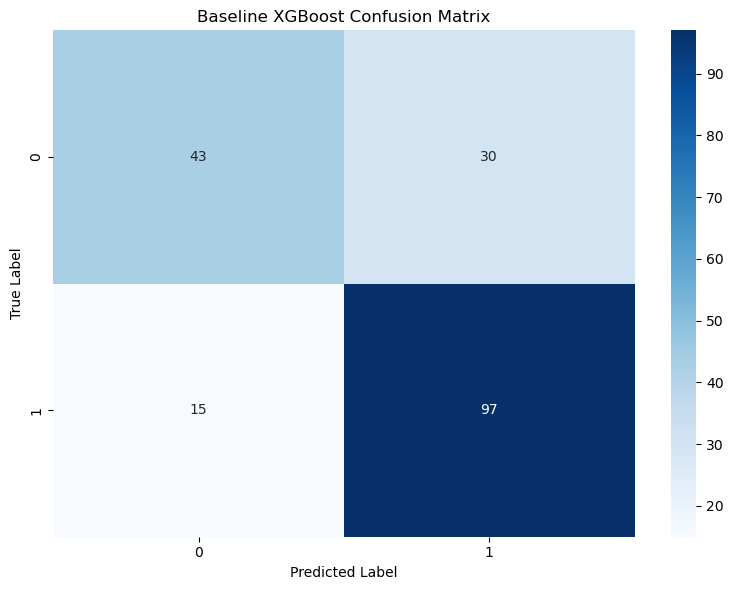

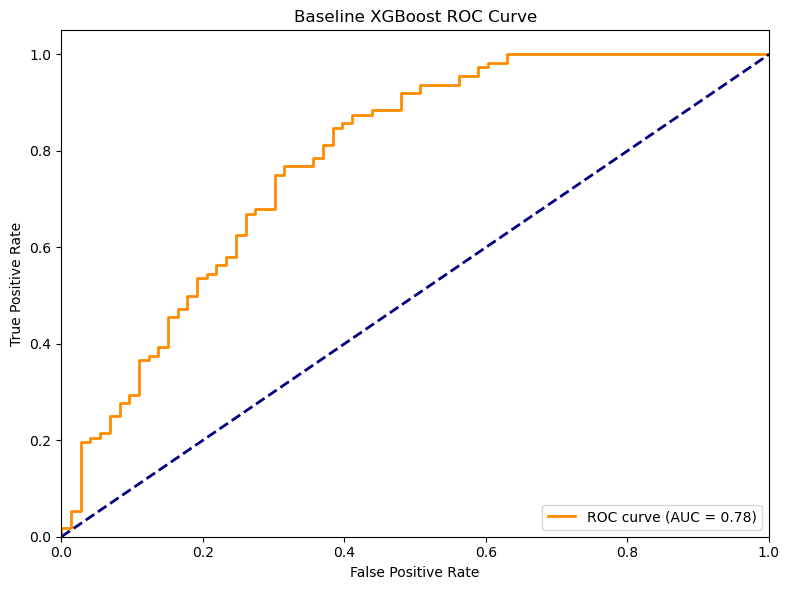

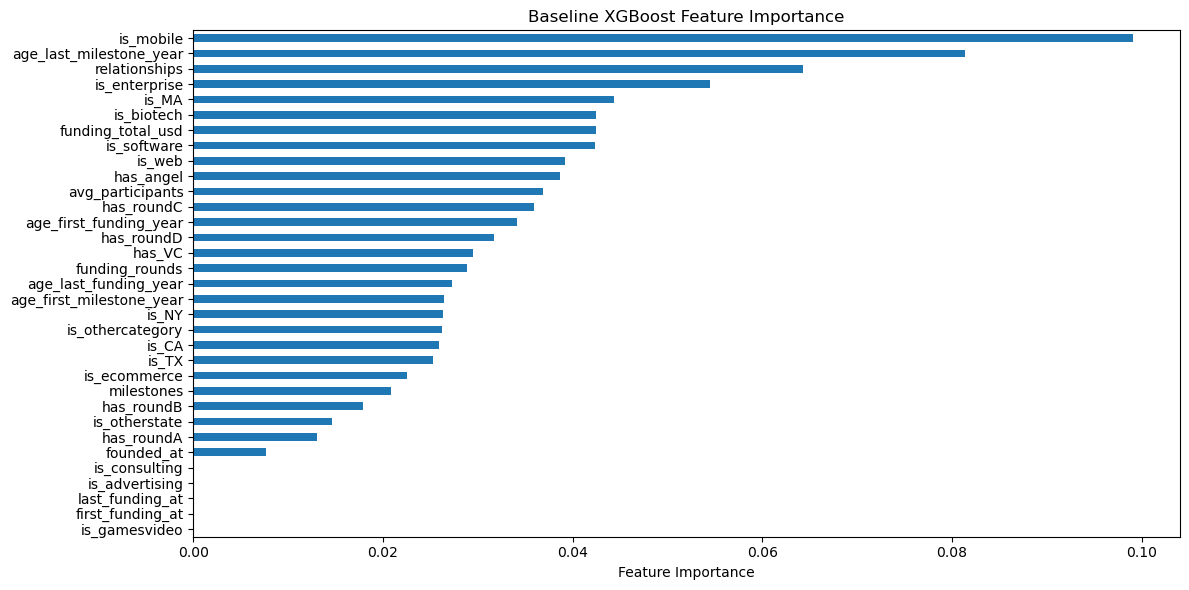


Baseline XGBoost Results:
F1 Score: 0.8117
ROC AUC: 0.7828
Precision: 0.7638
Recall: 0.8661

=== Experiment 1.5: SMOTE XGBoost ===

Class distribution before SMOTE:
labels
1    0.657182
0    0.342818
Name: proportion, dtype: float64

Class distribution after SMOTE:
labels
0    0.5
1    0.5
Name: proportion, dtype: float64


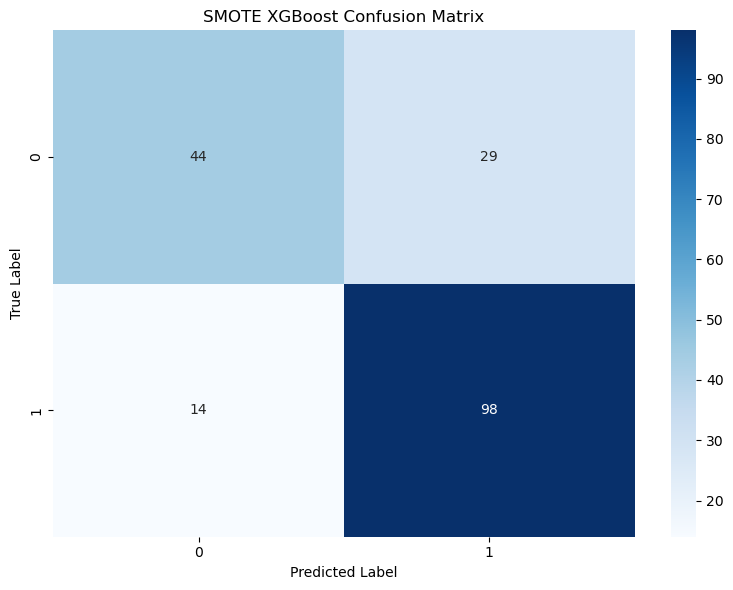

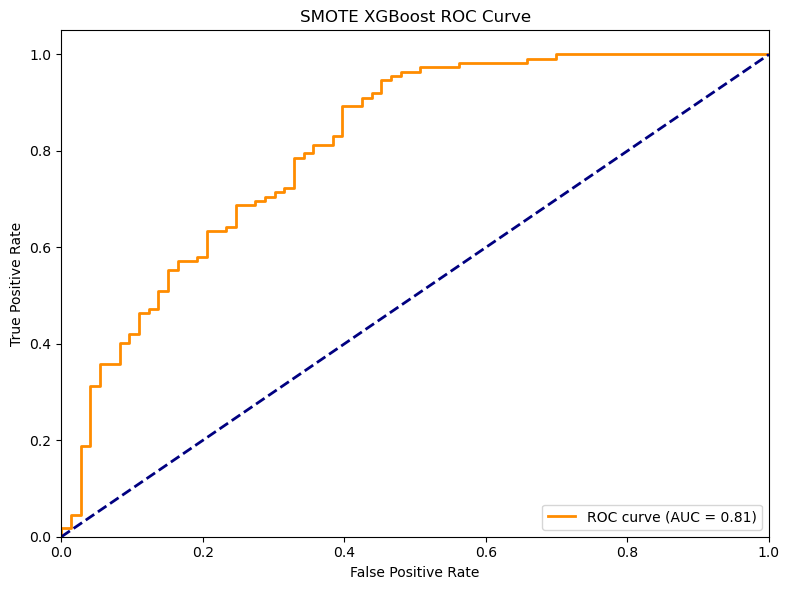

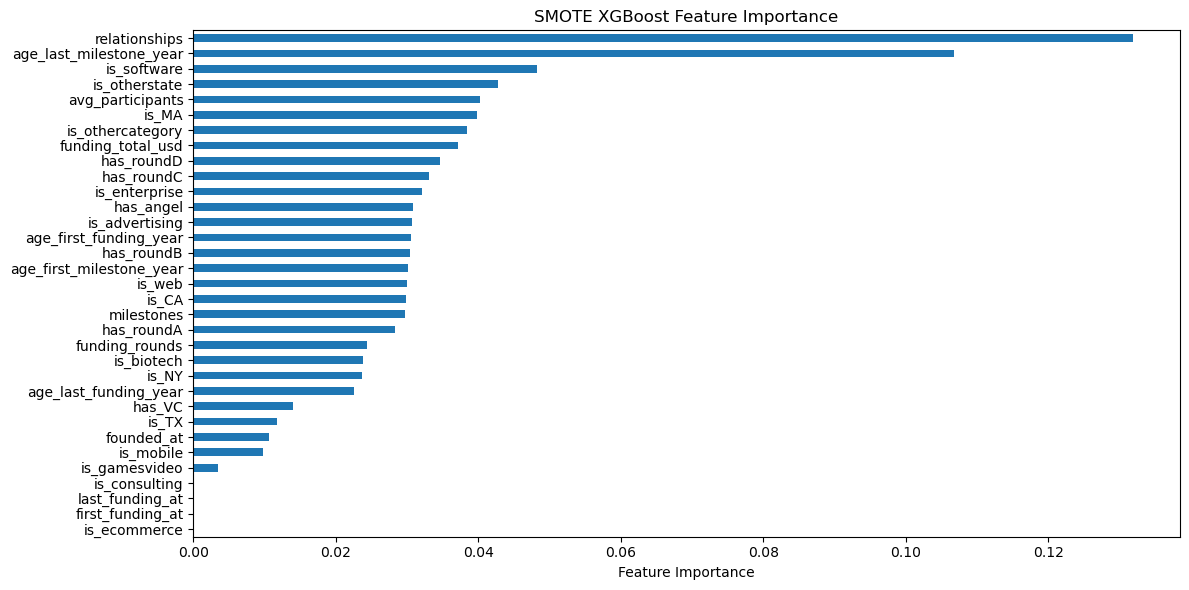


SMOTE XGBoost Results:
F1 Score: 0.8201
ROC AUC: 0.8105
Precision: 0.7717
Recall: 0.8750

=== Experiment 2: Time-Sorted XGBoost ===


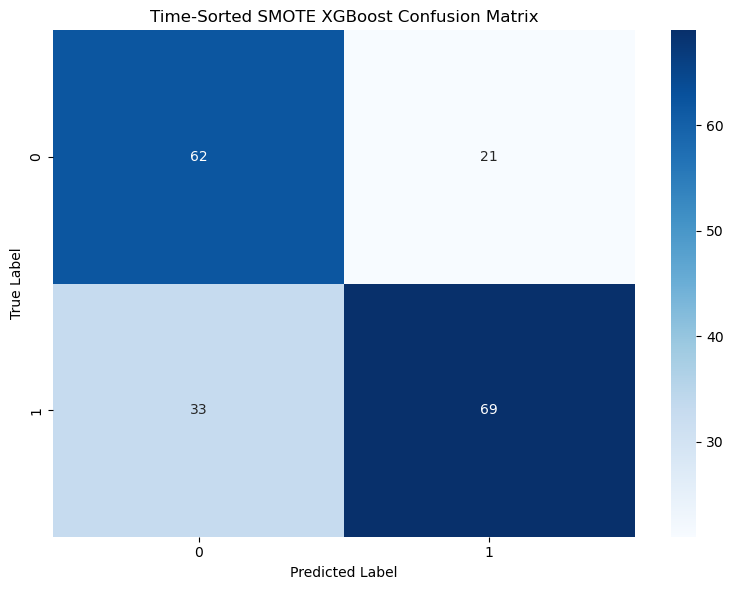

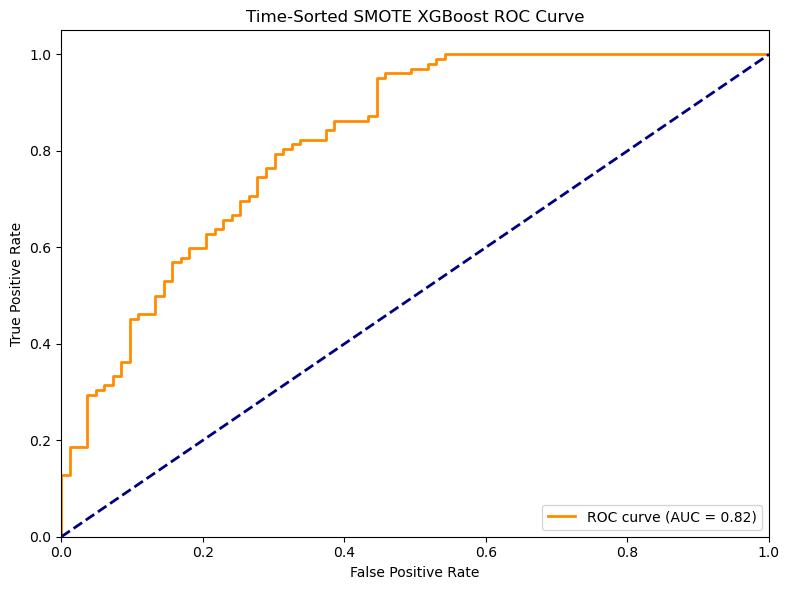

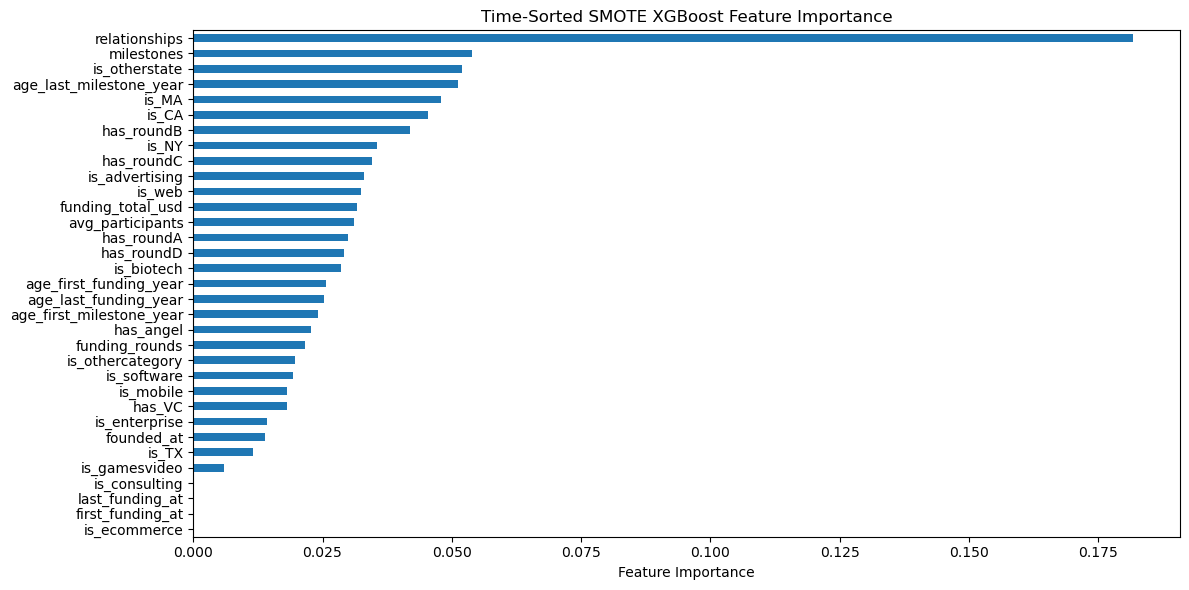


Time-Sorted SMOTE XGBoost Results:
F1 Score: 0.7188
ROC AUC: 0.8210
Precision: 0.7667
Recall: 0.6765

=== Experiment 3: XGBoost with Crisis Features ===


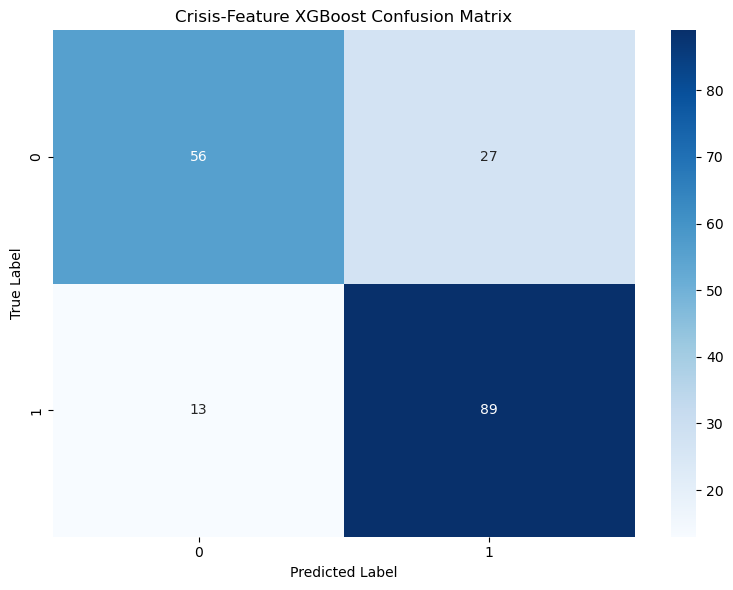

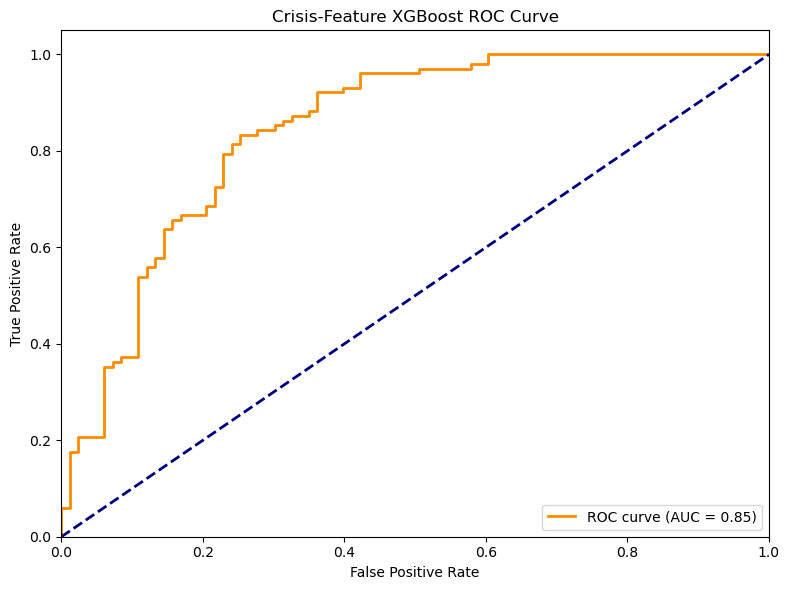

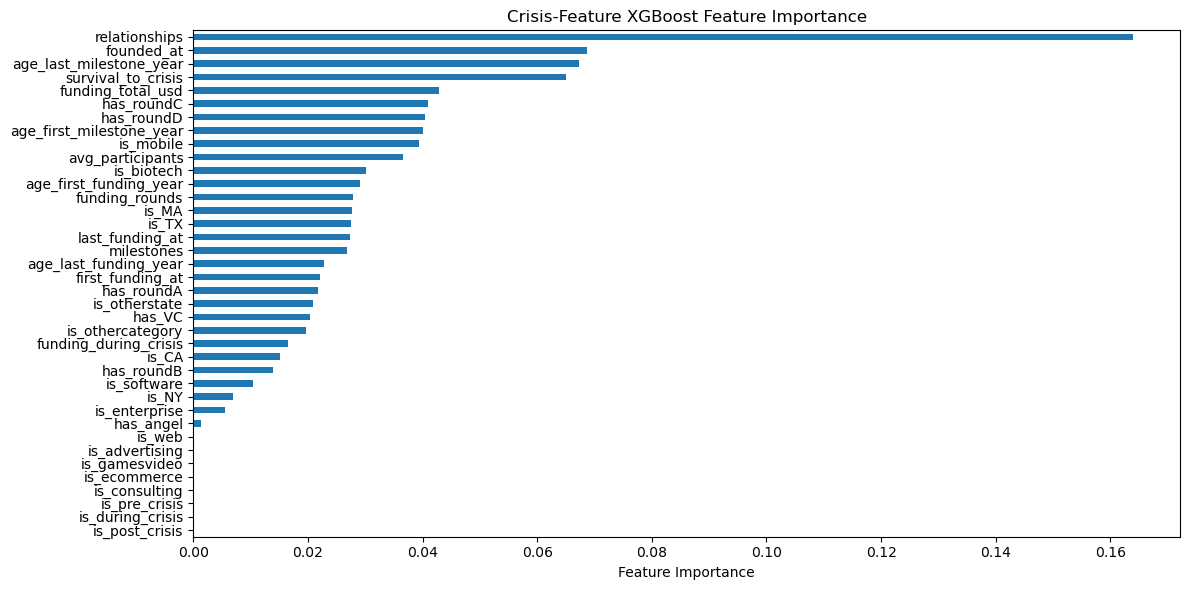


Crisis-Feature XGBoost Results:
F1 Score: 0.8165
ROC AUC: 0.8450
Precision: 0.7672
Recall: 0.8725

=== Final Results Comparison ===

Performance Comparison:
          Baseline     SMOTE  Time-Sorted
F1 Score  0.811715  0.820084     0.718750
ROC AUC   0.782779  0.810543     0.821049


In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

# 앞서 정의한 main_columns와 평가/시각화 함수들이 있다고 가정

def prepare_data(df):
    """데이터 전처리"""
    df = df.copy()
    
    # 날짜 컬럼 변환
    date_cols = ['founded_at', 'first_funding_at', 'last_funding_at']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col]).astype(np.int64) // 10**9
        
    X = df[main_columns].copy().reset_index(drop=True)
    y = df['labels'].copy().reset_index(drop=True)
    
    return X, y

def prepare_time_sorted_data(df, train_size=0.8):
    """시간순 정렬 및 분할"""
    # 시계열 순으로 정렬
    sorted_indices = df['founded_at'].argsort()
    X_sorted = df[main_columns].iloc[sorted_indices]
    y_sorted = df['labels'].iloc[sorted_indices]
    
    # 시간순으로 train/test 분할
    train_idx = int(len(X_sorted) * train_size)
    
    X_train = X_sorted[:train_idx]
    X_test = X_sorted[train_idx:]
    y_train = y_sorted[:train_idx]
    y_test = y_sorted[train_idx:]
    
    return X_train, X_test, y_train, y_test

def experiment_1_baseline():
    """실험 1: 기본 XGBoost"""
    print("\n=== Experiment 1: Baseline XGBoost ===")
    X, y = prepare_data(df)
    model, results = run_baseline_experiment(X, y)
    return model, results, X

def experiment_1_5_smote():
    """실험 1.5: SMOTE 적용한 XGBoost"""
    print("\n=== Experiment 1.5: SMOTE XGBoost ===")
    X, y = prepare_data(df)
    
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # SMOTE 적용
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # 클래스 분포 출력
    print("\nClass distribution before SMOTE:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1.0
    }
    model = XGBClassifier(random_state=42, **best_params)
    model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(model, X_test, y_test, 
                           X.columns, "SMOTE XGBoost")
    return model, results, X

def experiment_2_timeseries():
    """실험 2: 시계열 정렬 적용"""
    print("\n=== Experiment 2: Time-Sorted XGBoost ===")
    X, y = prepare_data(df)
    
    # 시계열 순으로 정렬
    sorted_indices = df['founded_at'].argsort()
    X_sorted = X.iloc[sorted_indices]
    y_sorted = y.iloc[sorted_indices]
    
    # founded_at 기준으로 시간 순서대로 80% 훈련, 20% 테스트
    train_size = int(len(X_sorted) * 0.8)
    
    X_train = X_sorted[:train_size]
    X_test = X_sorted[train_size:]
    y_train = y_sorted[:train_size]
    y_test = y_sorted[train_size:]
    
       # SMOTE 적용
    smote = SMOTE(random_state=42)    
    
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1.0
    }

    model = XGBClassifier(random_state=42, **best_params)
    model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(model, X_test, y_test, 
                           X.columns, "Time-Sorted SMOTE XGBoost")
    return model, results, X_sorted

def add_crisis_features(df):
    """금융위기 관련 피처 추가"""
    df = df.copy()
    
    crisis_start = pd.to_datetime('2008-01-01').timestamp()
    crisis_end = pd.to_datetime('2010-01-01').timestamp()
    
    df['is_pre_crisis'] = (df['founded_at'] < crisis_start).astype(int)
    df['is_during_crisis'] = ((df['founded_at'] >= crisis_start) & 
                             (df['founded_at'] < crisis_end)).astype(int)
    df['is_post_crisis'] = (df['founded_at'] >= crisis_end).astype(int)
    
    df['survival_to_crisis'] = crisis_start - df['founded_at']
    df['funding_during_crisis'] = ((df['first_funding_at'] <= crisis_end) & 
                                  (df['last_funding_at'] >= crisis_start)).astype(int)
    
    return df

def experiment_3_crisis_features():
    """실험 3: 금융위기 피처 추가"""
    print("\n=== Experiment 3: XGBoost with Crisis Features ===")
    
    # 금융위기 피처 추가
    df_crisis = add_crisis_features(df)
    crisis_columns = main_columns + [
        'is_pre_crisis', 'is_during_crisis', 'is_post_crisis',
        'survival_to_crisis', 'funding_during_crisis'
    ]
    
    df_crisis = add_crisis_features(df)
    X = df_crisis[crisis_columns].copy().reset_index(drop=True)
    y = df_crisis['labels'].copy().reset_index(drop=True)
    
    # 시계열 정렬 유지
    sorted_indices = df_crisis['founded_at'].argsort()
    X_sorted = X.iloc[sorted_indices]
    y_sorted = y.iloc[sorted_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sorted, y_sorted, test_size=0.2, shuffle=False
    )
    best_params = {
        'colsample_bytree': 0.8,
        'learning_rate': 0.01,
        'max_depth': 5,
        'min_child_weight': 1,
        'n_estimators': 200,
        'subsample': 1.0
    }
    model = XGBClassifier(random_state=42, **best_params)
    model.fit(X_train, y_train)
    
    results = evaluate_model(model, X_test, y_test, 
                           X.columns, "Crisis-Feature XGBoost")
    return model, results, X_sorted


def main():
    """메인 실험 실행"""
    # 실험 1: 기본 XGBoost
    model1, results1, X1 = experiment_1_baseline()
    
    # 실험 1.5: SMOTE 적용 XGBoost
    model1_5, results1_5, X1_5 = experiment_1_5_smote()
    
    # 실험 2: 시계열 정렬 적용
    model2, results2, X2 = experiment_2_timeseries()
    
    # 실험 3: 금융위기 피처 추가

    model3, results3, X3 = experiment_3_crisis_features()

    # 결과 비교
    print("\n=== Final Results Comparison ===")
    comparison = pd.DataFrame({
        'Baseline': [results1['f1_score'], results1['roc_auc']],
        'SMOTE': [results1_5['f1_score'], results1_5['roc_auc']],
        'Time-Sorted': [results2['f1_score'], results2['roc_auc']],
    }, index=['F1 Score', 'ROC AUC'])
    
    print("\nPerformance Comparison:")
    print(comparison)

if __name__ == "__main__":
    main()


=== Experiment 1: XGBoost with Cross Validation ===

Cross Validation Results:
                 train_mean  train_std  test_mean  test_std
test_accuracy           NaN        NaN   0.755194  0.031658
test_f1                 NaN        NaN   0.818771  0.022161
test_precision          NaN        NaN   0.786457  0.029410
test_recall             NaN        NaN   0.854314  0.022201
test_roc_auc            NaN        NaN   0.774468  0.053186
train_accuracy          1.0        0.0        NaN       NaN
train_f1                1.0        0.0        NaN       NaN
train_precision         1.0        0.0        NaN       NaN
train_recall            1.0        0.0        NaN       NaN
train_roc_auc           1.0        0.0        NaN       NaN

Feature Importance:


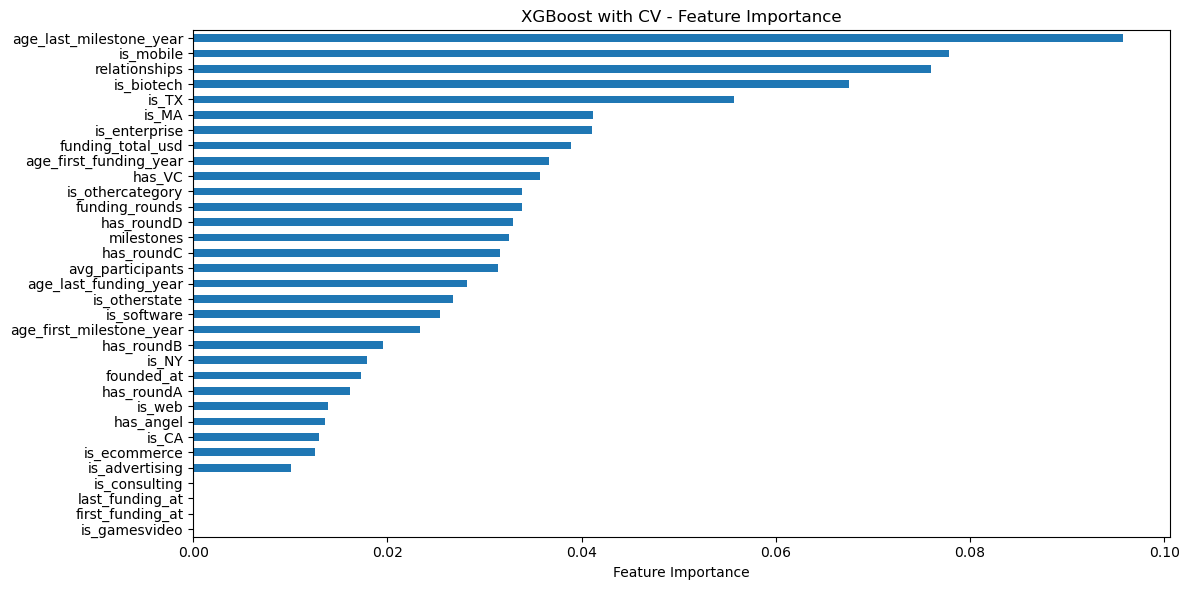

In [90]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

def experiment_1_with_cv():
    """교차검증이 포함된 기본 XGBoost 실험"""
    print("\n=== Experiment 1: XGBoost with Cross Validation ===")
    X, y = prepare_data(df)
    
    # 모델 정의
    model = XGBClassifier(random_state=42)
    
    # StratifiedKFold 정의 (클래스 비율 유지)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 여러 메트릭으로 교차검증 수행
    cv_results = cross_validate(
        model, X, y,
        cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'precision': 'precision',
            'recall': 'recall'
        },
        return_train_score=True
    )
    
    # 결과 정리
    metrics = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    cv_df = pd.DataFrame()
    
    for metric in metrics:
        cv_df[f'train_{metric}'] = cv_results[f'train_{metric}']
        cv_df[f'test_{metric}'] = cv_results[f'test_{metric}']
    
    # 평균과 표준편차 계산
    cv_summary = pd.DataFrame({
        'train_mean': cv_df.filter(like='train').mean(),
        'train_std': cv_df.filter(like='train').std(),
        'test_mean': cv_df.filter(like='test').mean(),
        'test_std': cv_df.filter(like='test').std()
    })
    
    print("\nCross Validation Results:")
    print(cv_summary)
    
    # 전체 데이터로 최종 모델 학습
    final_model = XGBClassifier(random_state=42)
    final_model.fit(X, y)
    
    return final_model, cv_summary, X

def main():
    """메인 실험 실행"""
    # 교차검증이 포함된 실험 실행
    model_cv, cv_summary, X = experiment_1_with_cv()
    
    # 특성 중요도 시각화
    print("\nFeature Importance:")
    plot_feature_importance(model_cv, X.columns, "XGBoost with CV - Feature Importance")

if __name__ == "__main__":
    main()


=== XGBoost Parameter Tuning with GridSearchCV ===
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters found:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}

Best cross-validation score: 0.8556

Top 5 parameter combinations:

Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Mean CV Score: 0.8556 (+/- 0.0654)

Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Mean CV Score: 0.8536 (+/- 0.0517)

Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Mean CV Score: 0.8525 (+/- 0.0617)

Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


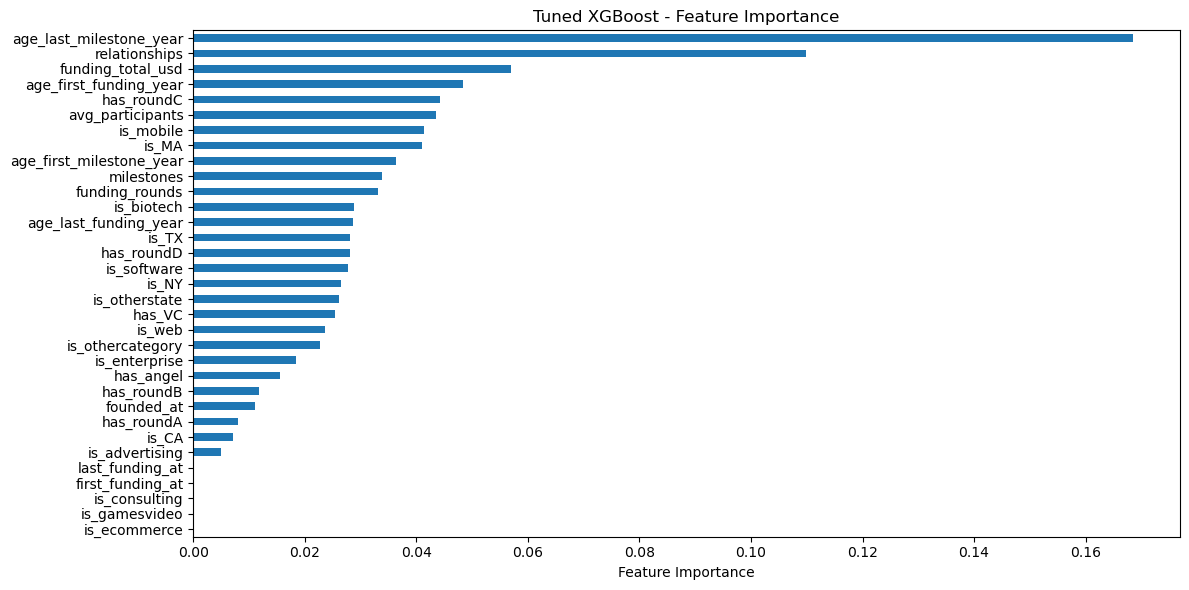

In [91]:
def experiment_parameter_tuning():
    """GridSearchCV를 이용한 XGBoost 파라미터 튜닝"""
    print("\n=== XGBoost Parameter Tuning with GridSearchCV ===")
    X, y = prepare_data(df)
    
    # 탐색할 파라미터 그리드 정의
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 200]
    }
    
    # 기본 모델 정의
    model = XGBClassifier(random_state=42)
    
    # CV 정의
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # GridSearchCV 정의
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    # 그리드 서치 수행
    grid_search.fit(X, y)
    
    # 최적 파라미터와 점수 출력
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")
    
    # 상위 5개 파라미터 조합 출력
    results = pd.DataFrame(grid_search.cv_results_)
    top_5_results = results.nlargest(5, 'mean_test_score')
    
    print("\nTop 5 parameter combinations:")
    for i, row in top_5_results.iterrows():
        params = {k[6:]: v for k, v in row.items() if k.startswith('param_')}
        print(f"\nParameters: {params}")
        print(f"Mean CV Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")
    
    # 최적 모델로 교차 검증 수행
    best_model = XGBClassifier(random_state=42, **grid_search.best_params_)
    cv_results = cross_validate(
        best_model, X, y,
        cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'precision': 'precision',
            'recall': 'recall'
        },
        return_train_score=True
    )
    
    # 결과 정리
    metrics = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    cv_df = pd.DataFrame()
    
    for metric in metrics:
        cv_df[f'train_{metric}'] = cv_results[f'train_{metric}']
        cv_df[f'test_{metric}'] = cv_results[f'test_{metric}']
    
    cv_summary = pd.DataFrame({
        'train_mean': cv_df.filter(like='train').mean(),
        'train_std': cv_df.filter(like='train').std(),
        'test_mean': cv_df.filter(like='test').mean(),
        'test_std': cv_df.filter(like='test').std()
    })
    
    print("\nCross Validation Results with Best Parameters:")
    print(cv_summary)
    
    # 전체 데이터로 최종 모델 학습
    final_model = XGBClassifier(random_state=42, **grid_search.best_params_)
    final_model.fit(X, y)
    
    return final_model, cv_summary, X

if __name__ == "__main__":
    best_model, cv_summary, X = experiment_parameter_tuning()
    print("\nFeature Importance of Best Model:")
    plot_feature_importance(best_model, X.columns, "Tuned XGBoost - Feature Importance")


=== XGBoost with Best Parameters and Selected Features ===

Cross Validation Results:
                 train_mean  train_std  test_mean  test_std
test_accuracy           NaN        NaN   0.785576  0.052959
test_f1                 NaN        NaN   0.848031  0.037306
test_precision          NaN        NaN   0.783234  0.036782
test_recall             NaN        NaN   0.924664  0.039208
test_roc_auc            NaN        NaN   0.817989  0.042977
train_accuracy     0.871074   0.008924        NaN       NaN
train_f1           0.908447   0.005961        NaN       NaN
train_precision    0.840276   0.008729        NaN       NaN
train_recall       0.988692   0.003511        NaN       NaN
train_roc_auc      0.938504   0.006082        NaN       NaN

Feature Importance of Best Model:


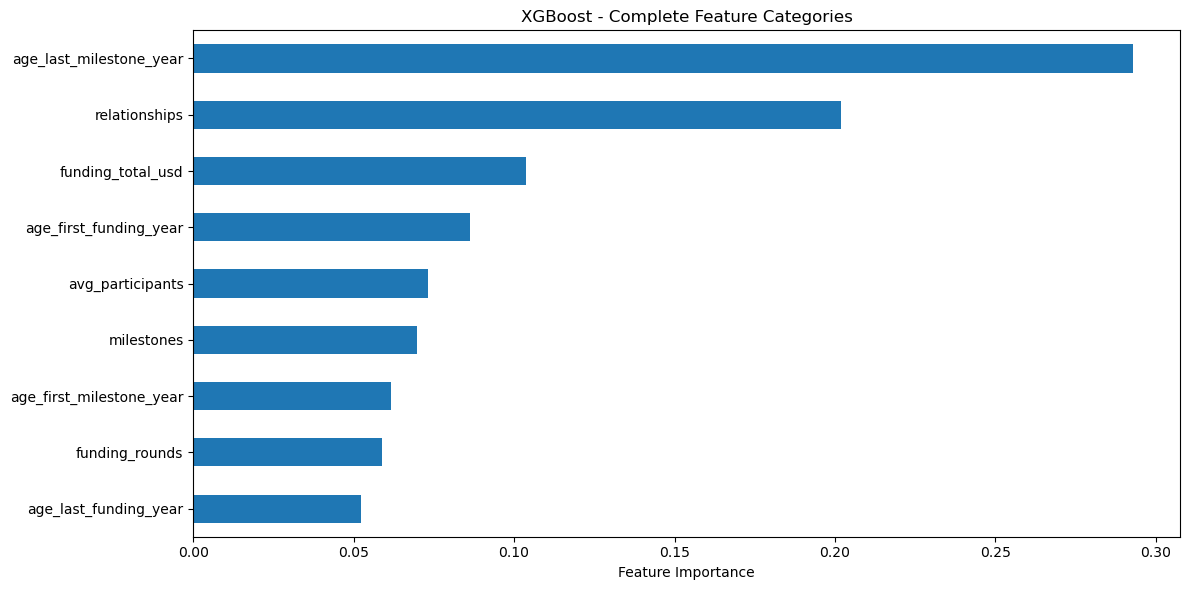

In [92]:
def prepare_data_reduced(df):
    """중요 피처만 선택하여 데이터 전처리"""
    df = df.copy()
    
    # 기본 수치형 피처

    
    # 투자 라운드 관련 피처 (전체 포함)
    round_features = [
        'has_VC', 'has_angel', 
        'has_roundA', 'has_roundB', 
        'has_roundC', 'has_roundD'
    ]
    
    # 주 관련 피처 (전체 포함)
    state_features = [
        'is_CA', 'is_NY', 'is_MA', 
        'is_TX', 'is_otherstate'
    ]
    
    # 산업 관련 피처 (전체 포함)
    industry_features = [
        'is_software', 'is_web', 'is_mobile',
        'is_enterprise', 'is_advertising',
        'is_gamesvideo', 'is_ecommerce',
        'is_biotech', 'is_consulting',
        'is_othercategory'
    ]
    
    selected_features = base_features
    
    X = df[selected_features].copy().reset_index(drop=True)
    y = df['labels'].copy().reset_index(drop=True)
    
    return X, y

def experiment_with_best_params():
    """최적 파라미터를 사용한 XGBoost 실험"""
    print("\n=== XGBoost with Best Parameters and Selected Features ===")
    X, y = prepare_data_reduced(df)
    
    # 이전에 찾은 최적 파라미터 사용
    best_params = {
        'colsample_bytree': 0.8,
        'learning_rate': 0.01,
        'max_depth': 5,
        'min_child_weight': 1,
        'n_estimators': 200,
        'subsample': 1.0
    }
    
    # CV 정의
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 모델 학습 및 교차 검증
    model = XGBClassifier(random_state=42, **best_params)
    cv_results = cross_validate(
        model, X, y,
        cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'precision': 'precision',
            'recall': 'recall'
        },
        return_train_score=True
    )
    
    # 결과 정리
    metrics = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    cv_df = pd.DataFrame()
    
    for metric in metrics:
        cv_df[f'train_{metric}'] = cv_results[f'train_{metric}']
        cv_df[f'test_{metric}'] = cv_results[f'test_{metric}']
    
    cv_summary = pd.DataFrame({
        'train_mean': cv_df.filter(like='train').mean(),
        'train_std': cv_df.filter(like='train').std(),
        'test_mean': cv_df.filter(like='test').mean(),
        'test_std': cv_df.filter(like='test').std()
    })
    
    print("\nCross Validation Results:")
    print(cv_summary)
    
    # 전체 데이터로 최종 모델 학습
    final_model = XGBClassifier(random_state=42, **best_params)
    final_model.fit(X, y)
    
    return final_model, cv_summary, X

if __name__ == "__main__":
    best_model, cv_summary, X = experiment_with_best_params()
    print("\nFeature Importance of Best Model:")
    plot_feature_importance(best_model, X.columns, "XGBoost - Complete Feature Categories")

In [93]:
def prepare_data_without_outliers(df):
    """이상치가 제거된 데이터 준비"""
    df = df.copy()
    
    # 사용할 기본 수치형 피처
    numeric_features = [
        'age_last_milestone_year',
        'relationships',
        'funding_total_usd',
        'age_first_funding_year',
        'avg_participants',
        'milestones',
        'age_first_milestone_year',
        'funding_rounds',
        'age_last_funding_year'
    ]
    
    # 이상치 제거
    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    print(f"\n제거 후 남은 데이터 수: {len(df)} (제거된 데이터 수: {923-len(df)})")
    
    X = df[numeric_features].copy().reset_index(drop=True)
    y = df['labels'].copy().reset_index(drop=True)
    
    return X, y



=== Baseline Model ===

Cross Validation Results:
                 train_mean  train_std  test_mean  test_std
test_accuracy           NaN        NaN   0.787295  0.026661
test_f1                 NaN        NaN   0.844951  0.019828
test_precision          NaN        NaN   0.811297  0.024620
test_recall             NaN        NaN   0.882474  0.033880
test_roc_auc            NaN        NaN   0.807361  0.028260
train_accuracy          1.0        0.0        NaN       NaN
train_f1                1.0        0.0        NaN       NaN
train_precision         1.0        0.0        NaN       NaN
train_recall            1.0        0.0        NaN       NaN
train_roc_auc           1.0        0.0        NaN       NaN

Test Set Evaluation:


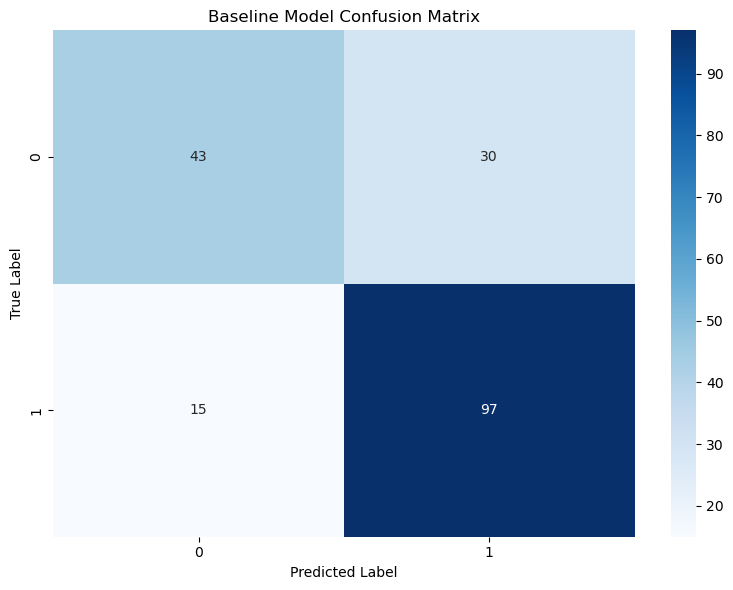

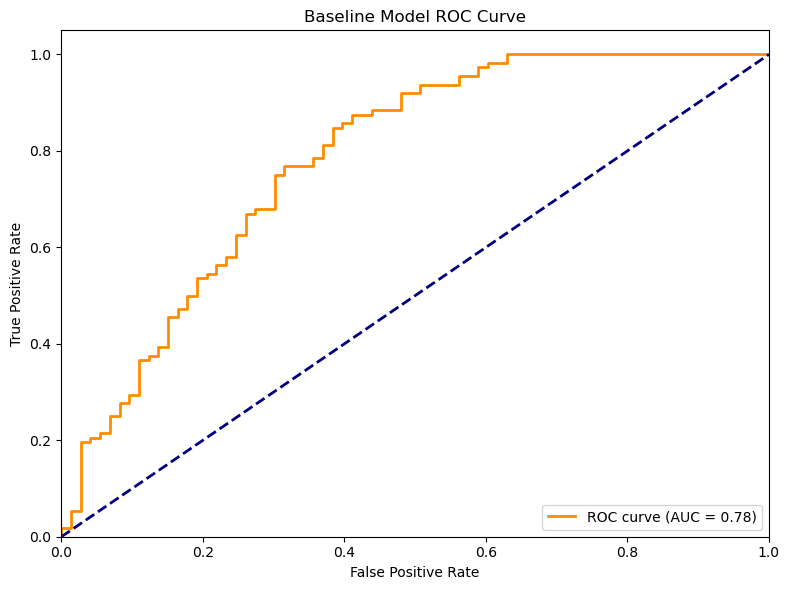

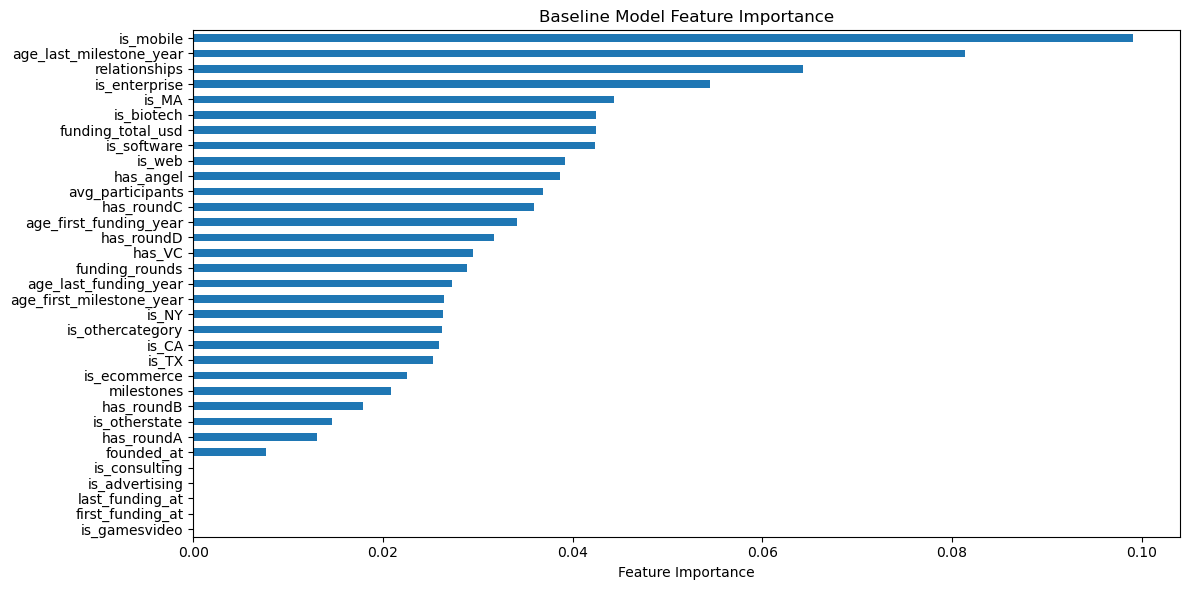


Baseline Model Results:
F1 Score: 0.8117
ROC AUC: 0.7828
Precision: 0.7638
Recall: 0.8661

=== Tuned Model ===

Cross Validation Results:
                 train_mean  train_std  test_mean  test_std
test_accuracy           NaN        NaN   0.787341  0.026603
test_f1                 NaN        NaN   0.853706  0.018444
test_precision          NaN        NaN   0.779180  0.020315
test_recall             NaN        NaN   0.944330  0.023734
test_roc_auc            NaN        NaN   0.816191  0.025178
train_accuracy     0.870597   0.004985        NaN       NaN
train_f1           0.909228   0.003252        NaN       NaN
train_precision    0.843505   0.005508        NaN       NaN
train_recall       0.986082   0.002939        NaN       NaN
train_roc_auc      0.952109   0.004314        NaN       NaN

Test Set Evaluation:


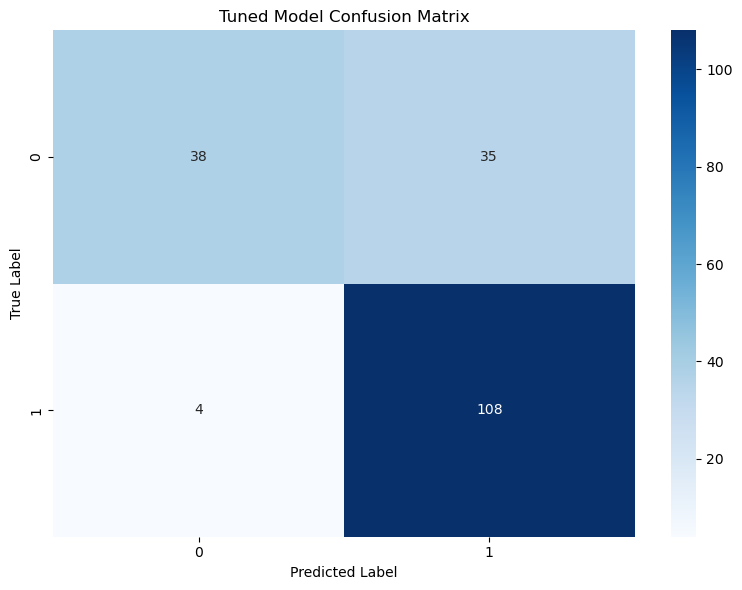

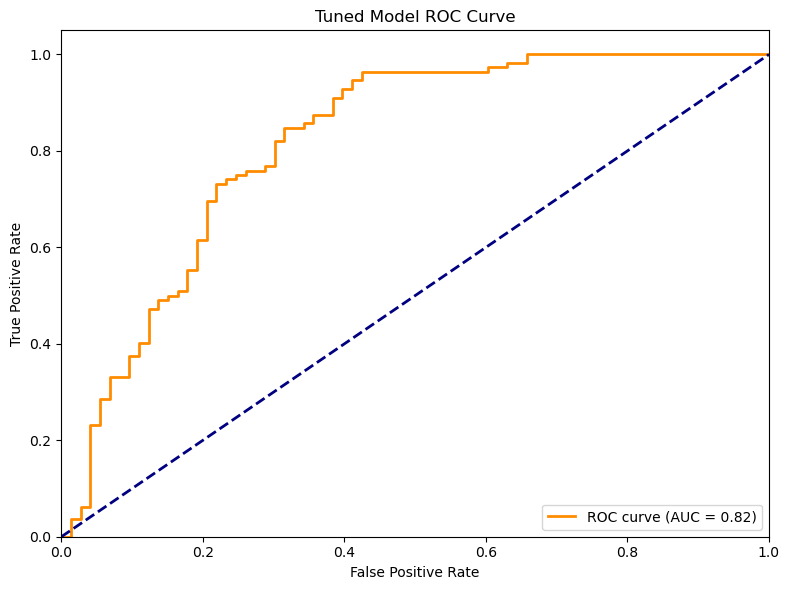

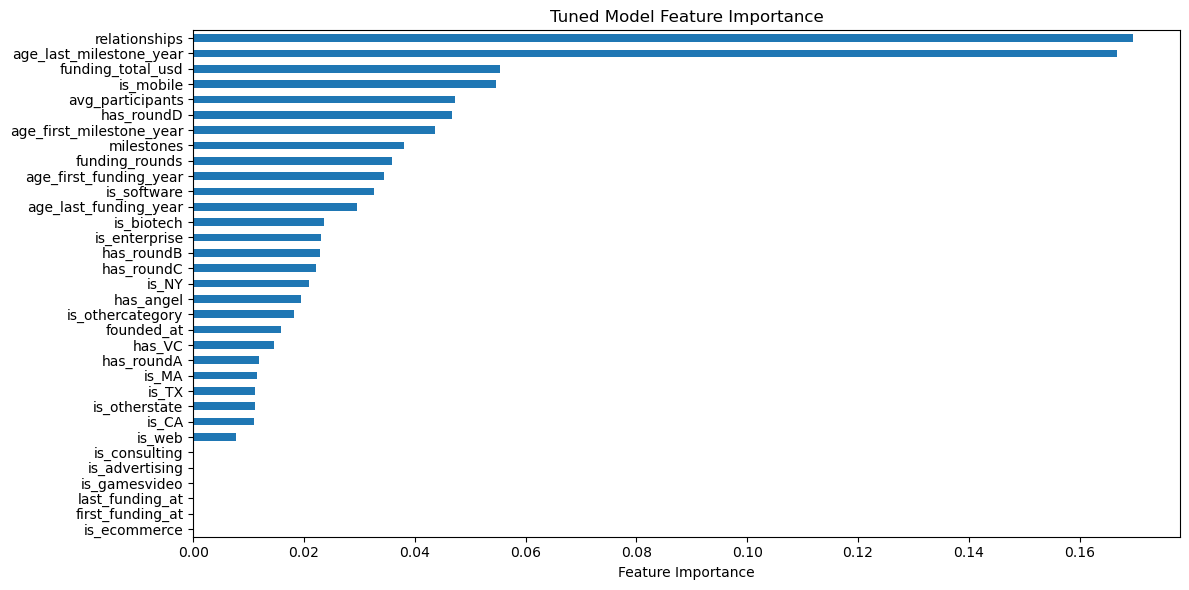


Tuned Model Results:
F1 Score: 0.8471
ROC AUC: 0.8186
Precision: 0.7552
Recall: 0.9643

=== Selected Features Model ===

Cross Validation Results:
                 train_mean  train_std  test_mean  test_std
test_accuracy           NaN        NaN   0.791432  0.036216
test_f1                 NaN        NaN   0.856144  0.024784
test_precision          NaN        NaN   0.783412  0.027807
test_recall             NaN        NaN   0.944330  0.030582
test_roc_auc            NaN        NaN   0.818816  0.028758
train_accuracy     0.869919   0.002773        NaN       NaN
train_f1           0.908835   0.001691        NaN       NaN
train_precision    0.842467   0.004796        NaN       NaN
train_recall       0.986598   0.004958        NaN       NaN
train_roc_auc      0.945079   0.005424        NaN       NaN

Test Set Evaluation:


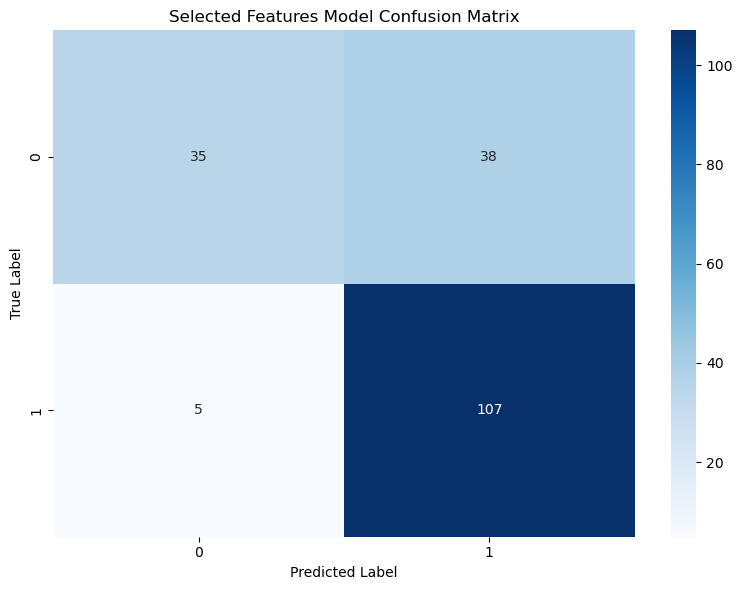

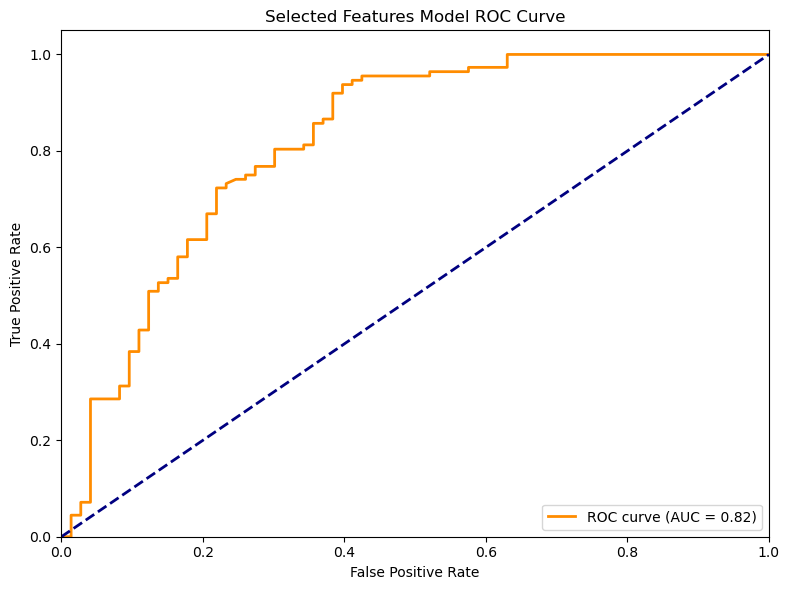

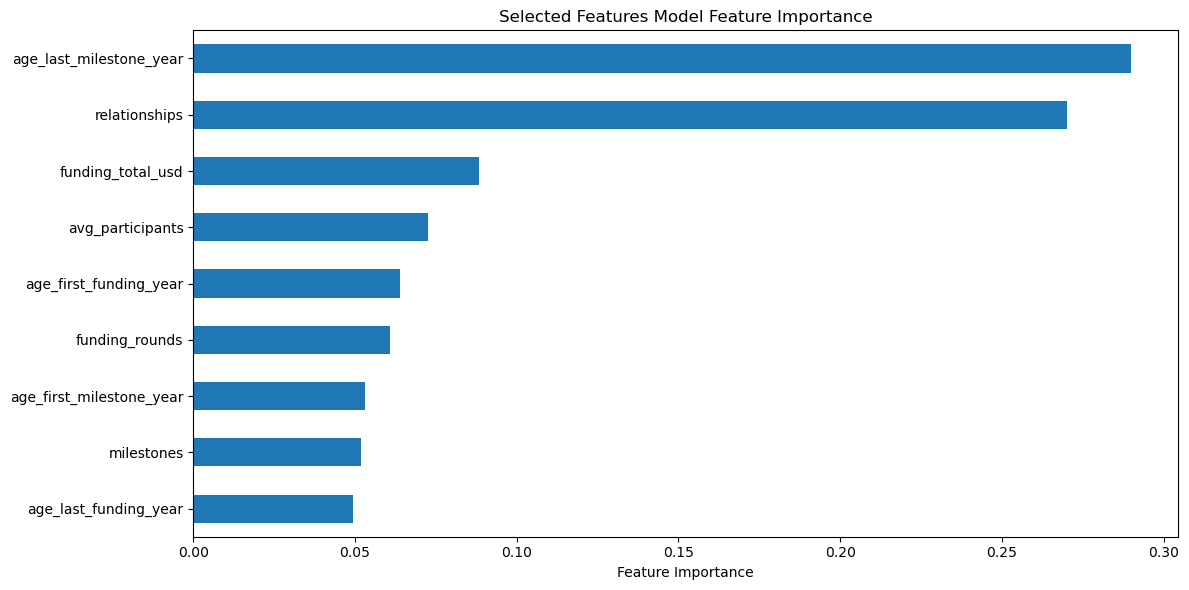


Selected Features Model Results:
F1 Score: 0.8327
ROC AUC: 0.8195
Precision: 0.7379
Recall: 0.9554

=== Clean Data Model ===

Cross Validation Results:
                 train_mean  train_std  test_mean  test_std
test_accuracy           NaN        NaN   0.759351  0.034668
test_f1                 NaN        NaN   0.829822  0.020338
test_precision          NaN        NaN   0.753824  0.035890
test_recall             NaN        NaN   0.924613  0.027610
test_roc_auc            NaN        NaN   0.793747  0.027403
train_accuracy     0.856653   0.005606        NaN       NaN
train_f1           0.896482   0.004147        NaN       NaN
train_precision    0.825770   0.003943        NaN       NaN
train_recall       0.980453   0.006051        NaN       NaN
train_roc_auc      0.951842   0.004763        NaN       NaN

Test Set Evaluation:


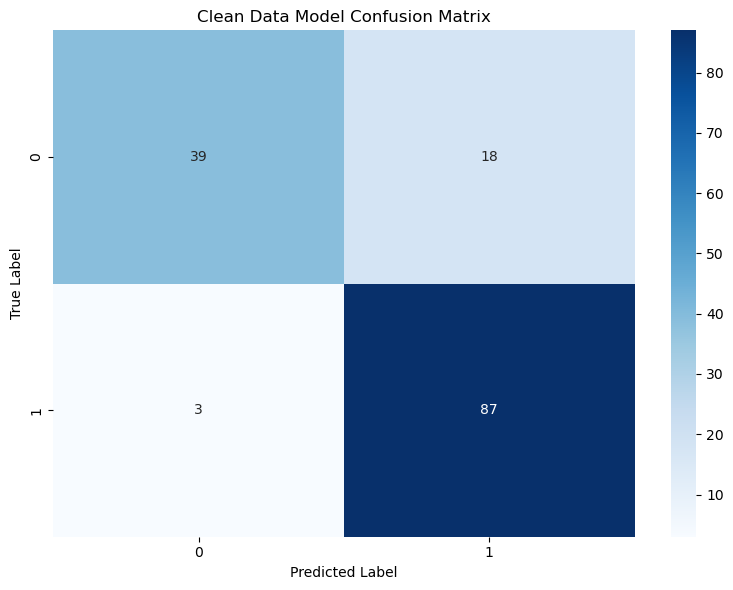

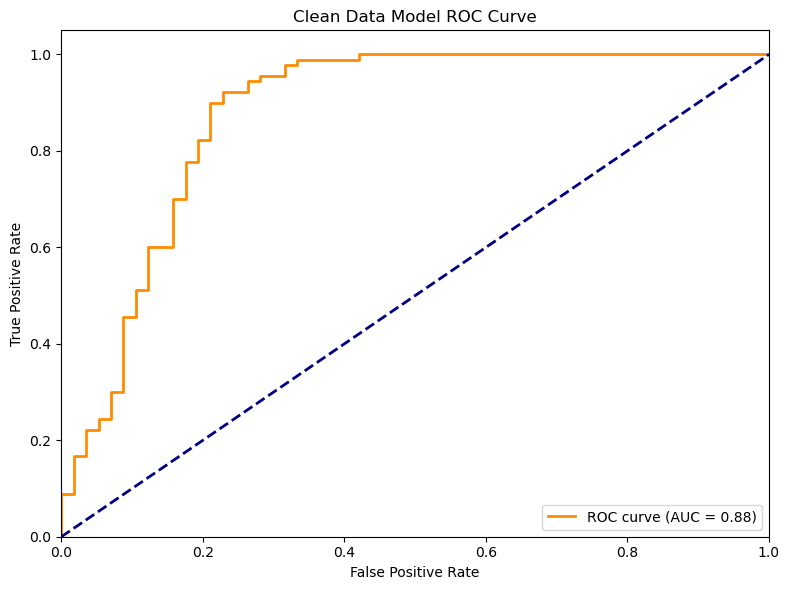

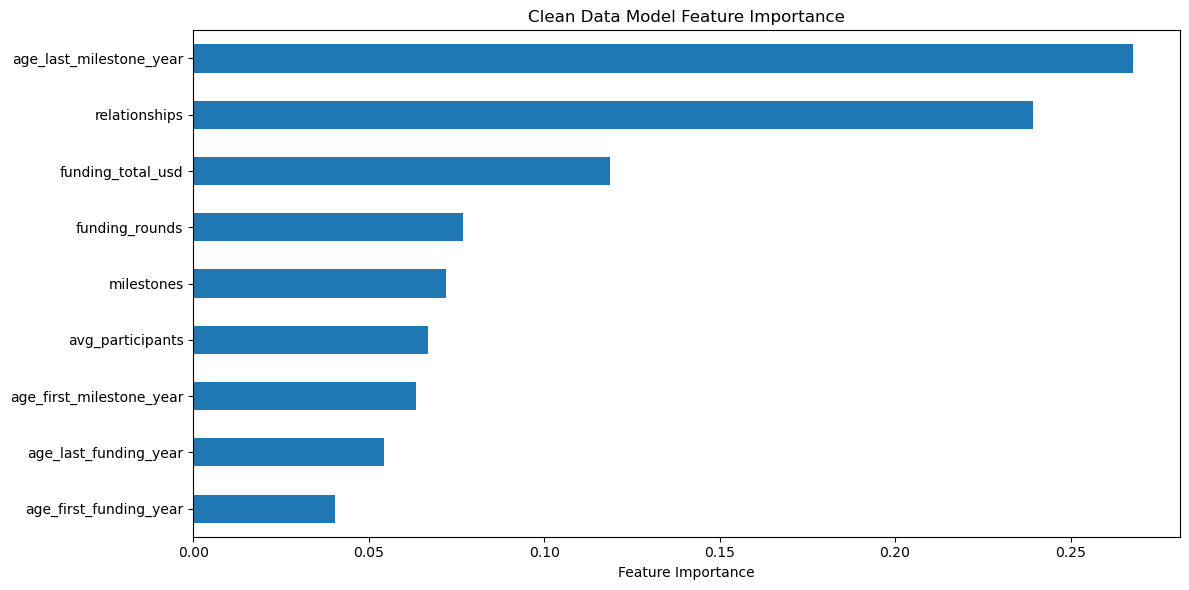


Clean Data Model Results:
F1 Score: 0.8923
ROC AUC: 0.8774
Precision: 0.8286
Recall: 0.9667

=== Clean Data Model + SMOTE ===

Cross Validation Results:
                 train_mean  train_std  test_mean  test_std
test_accuracy           NaN        NaN   0.774766  0.044950
test_f1                 NaN        NaN   0.800172  0.030920
test_precision          NaN        NaN   0.740117  0.064575
test_recall             NaN        NaN   0.875509  0.032342
test_roc_auc            NaN        NaN   0.859289  0.033722
train_accuracy     0.890769   0.006826        NaN       NaN
train_f1           0.900144   0.005718        NaN       NaN
train_precision    0.845685   0.010731        NaN       NaN
train_recall       0.962199   0.005568        NaN       NaN
train_roc_auc      0.962145   0.001767        NaN       NaN

Test Set Evaluation:


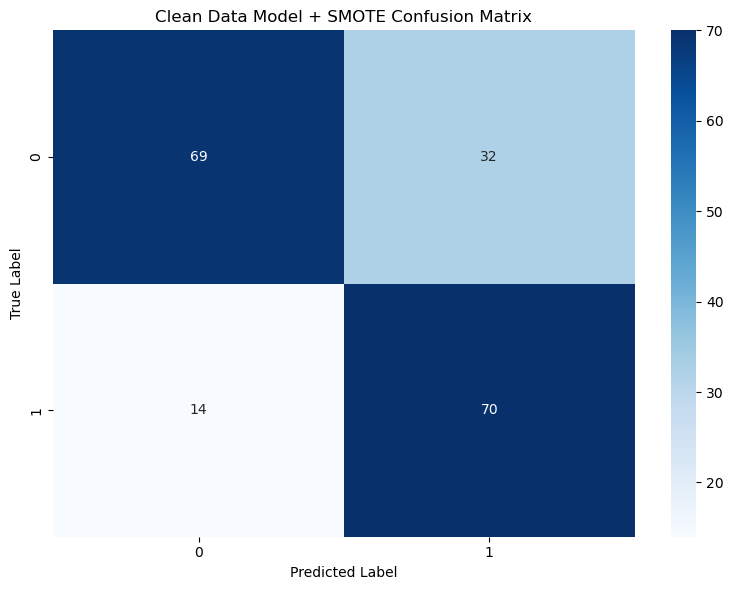

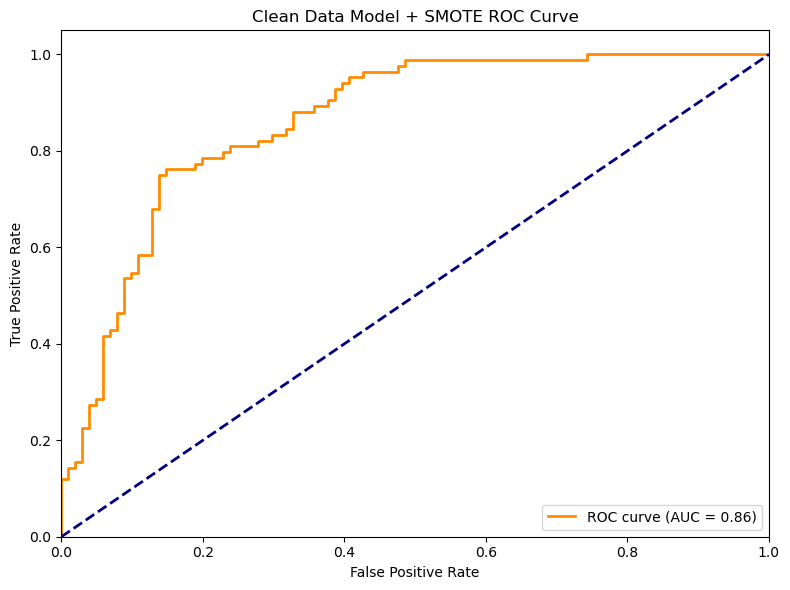

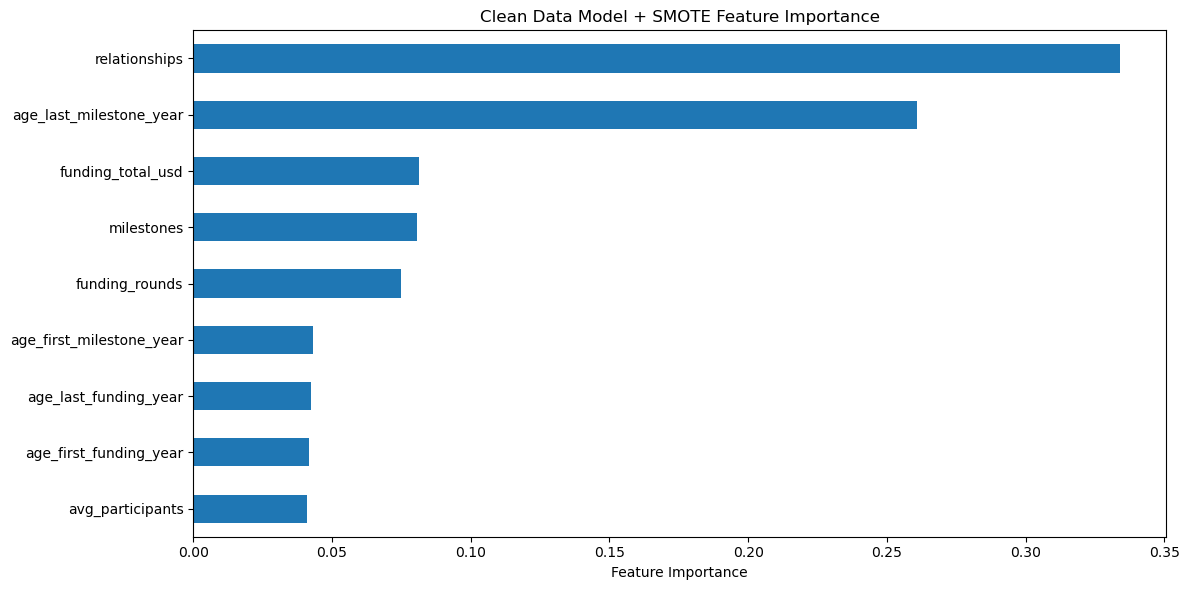


Clean Data Model + SMOTE Results:
F1 Score: 0.7527
ROC AUC: 0.8629
Precision: 0.6863
Recall: 0.8333


In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from xgboost import XGBClassifier


base_features = [
    'age_last_milestone_year',
    'age_first_milestone_year',
    'age_first_funding_year',
    'age_last_funding_year',
    'relationships',
    'funding_total_usd',
    'avg_participants',
    'milestones',
    'funding_rounds'
]


def run_experiment(X, y, model, title, cv=5):
    """교차검증과 최종 평가 수행"""
    # 훈련/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train, y_test = np.array(y_train), np.array(y_test)
    
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # 교차 검증 (훈련 데이터로만)
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'precision': 'precision',
            'recall': 'recall'
        },
        return_train_score=True
    )
    
    # CV 결과 정리
    metrics = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    cv_df = pd.DataFrame()
    
    for metric in metrics:
        cv_df[f'train_{metric}'] = cv_results[f'train_{metric}']
        cv_df[f'test_{metric}'] = cv_results[f'test_{metric}']
    
    cv_summary = pd.DataFrame({
        'train_mean': cv_df.filter(like='train').mean(),
        'train_std': cv_df.filter(like='train').std(),
        'test_mean': cv_df.filter(like='test').mean(),
        'test_std': cv_df.filter(like='test').std()
    })
    
    print(f"\n=== {title} ===")
    print("\nCross Validation Results:")
    print(cv_summary)
    
    # 전체 훈련 데이터로 최종 모델 학습
    model.fit(X_train, y_train)
    
    # 테스트 세트로 최종 평가
    print("\nTest Set Evaluation:")
    evaluate_model(model, X_test, y_test, X.columns, title)
    
    return model, cv_summary

# 데이터 준비
X, y = prepare_data(df)

# 실험 실행
base_model = XGBClassifier(random_state=42)
base_results = run_experiment(X, y, base_model, "Baseline Model")


# 2. 그리드서치로 찾은 최적 파라미터 적용
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1.0,
    'reg_alpha': 0.5,    # L1 정규화
    'reg_lambda': 2.0    # L2 정규화
}
tuned_model = XGBClassifier(random_state=42, **best_params)
tuned_results = run_experiment(X, y, tuned_model, "Tuned Model")

# 3. 선택된 피처로 실험
selected_features = [
    'age_last_milestone_year', 'relationships', 'funding_total_usd',
    'age_first_funding_year', 'avg_participants', 'milestones',
    'age_first_milestone_year', 'funding_rounds', 'age_last_funding_year'
]
X_selected = X[selected_features]
selected_results = run_experiment(X_selected, y, tuned_model, "Selected Features Model")

# 4. 이상치 제거 후 실험
def remove_outliers(df, features):
    df = df.copy()
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)]
    return df

X_clean = remove_outliers(X_selected, selected_features)
y_clean = y[X_clean.index]
clean_results = run_experiment(X_clean, y_clean, tuned_model, "Clean Data Model")

# 5. 4번실험 + STMOE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_clean, y_clean)

clean_results = run_experiment(X_train_balanced, y_train_balanced, tuned_model, "Clean Data Model + SMOTE")